In [1]:
import os
import cv2
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from os import listdir
from monai.transforms import Compose, Resize, ScaleIntensity, LoadImage

In [2]:
path = '../data/processed'
img_size = 112
frames = 64

# Formatação DataFrame

Vou formatar o csv
contendo as informações, selecionar algumas colunas que eu acho necessário

In [3]:
df_train = pd.read_csv(path+'/train.csv')

In [4]:
df_train.head()

,StudyInstanceUID,SeriesInstanceUID,SOPInstanceUID,pe_present_on_image,negative_exam_for_pe,qa_motion,qa_contrast,flow_artifact,rv_lv_ratio_gte_1,rv_lv_ratio_lt_1,leftsided_pe,chronic_pe,true_filling_defect_not_pe,rightsided_pe,acute_and_chronic_pe,central_pe,indeterminate
0,6897fa9de148,2bfbb7fd2e8b,0123_c0f3cb036d06,0,0,0,0,0,0,1,1,0,0,1,0,0,0
1,6897fa9de148,2bfbb7fd2e8b,0114_f57ffd3883b6,0,0,0,0,0,0,1,1,0,0,1,0,0,0
2,6897fa9de148,2bfbb7fd2e8b,0024_41220fda34a3,0,0,0,0,0,0,1,1,0,0,1,0,0,0
3,6897fa9de148,2bfbb7fd2e8b,0023_13b685b4b14f,0,0,0,0,0,0,1,1,0,0,1,0,0,0
4,6897fa9de148,2bfbb7fd2e8b,0022_be0b7524ffb4,0,0,0,0,0,0,1,1,0,0,1,0,0,0


In [5]:
columns = ['StudyInstanceUID', 'SeriesInstanceUID', 'SOPInstanceUID', 'negative_exam_for_pe', 'rightsided_pe', 'central_pe', 'leftsided_pe']

In [6]:
df_train = df_train[columns]

In [7]:
df_train = df_train.rename(columns={"negative_exam_for_pe": "result_pe"})

In [9]:
def inverte_result(x):
    if x == 0:
        return 1
    else:
        return 0

In [10]:
df_train['result_pe'] = df_train['result_pe'].apply(inverte_result)

In [11]:
df_train = df_train.drop_duplicates('StudyInstanceUID')

In [12]:
df_train = df_train.reset_index(drop=True)

In [13]:
df_train.head()

,StudyInstanceUID,SeriesInstanceUID,SOPInstanceUID,result_pe,rightsided_pe,central_pe,leftsided_pe
0,6897fa9de148,2bfbb7fd2e8b,0123_c0f3cb036d06,1,1,0,1
1,013358b540bb,2805267980e7,0144_c4cce735427f,0,0,0,0
2,0cee26703028,bac7becd2970,0143_648654d7154c,1,1,0,0
3,c28f3d01b14f,7d17c72fd0ce,0104_a3cba934ec3c,1,0,0,1
4,c8fbf1e08ac5,275497911f02,0080_0b9418e3c60a,0,0,0,0


In [14]:
df_train.to_csv(path+'/train_apply.csv')

In [15]:
df = df_train

In [16]:
df.head()

,StudyInstanceUID,SeriesInstanceUID,SOPInstanceUID,result_pe
0,6897fa9de148,2bfbb7fd2e8b,0123_c0f3cb036d06,1
1,013358b540bb,2805267980e7,0144_c4cce735427f,0
2,0cee26703028,bac7becd2970,0143_648654d7154c,1
3,c28f3d01b14f,7d17c72fd0ce,0104_a3cba934ec3c,1
4,c8fbf1e08ac5,275497911f02,0080_0b9418e3c60a,0


# Resize shape e aumentando a escala de intensidade

Essas vão ser as operações que irei efetuar no conjunto de dados, basicamente eu vou ter um paciente com uma classificação e esse conjunto de imagens irão formar um shape = (C,F,W,H)

C = channels de cores
F = frames da imagem
W = largura da imagem
H = altura da imagem

In [17]:
transform_data = Compose([  ScaleIntensity(), Resize((frames, img_size, img_size)) ])

rodando um exemplo para ver o resultado dos mesmos

In [18]:
row = df.iloc[0]

path_img = path + '/train-jpegs/' + row['StudyInstanceUID'] + '/' + row['SeriesInstanceUID']
imgs_array = sorted([ path_img + '/' + img_path for img_path in listdir(path_img) ])
imgs_input = np.stack([ np.asarray(cv2.imread(img)).astype(np.float32) for img in imgs_array ]).transpose(3,0,1,2)

img_np = transform_data(imgs_input)

In [21]:
def plot_scans(scans, rows = 5, cols = 6, interval = 2):
    
    fig,ax = plt.subplots(rows,cols,figsize=[20,20])
    index = 0
    
    for i in range(rows):
        for j in range(cols):
        
            scan = scans[:, index, : , :].transpose(1,2,0)
            ax[i, j].set_title(f'Scan {index+1}')
            ax[i, j].imshow( scan, cmap='bone')
            ax[i, j].axis('off')
            index += 1
            
    plt.show()

# Plot dos dados após a formatação dos mesmos

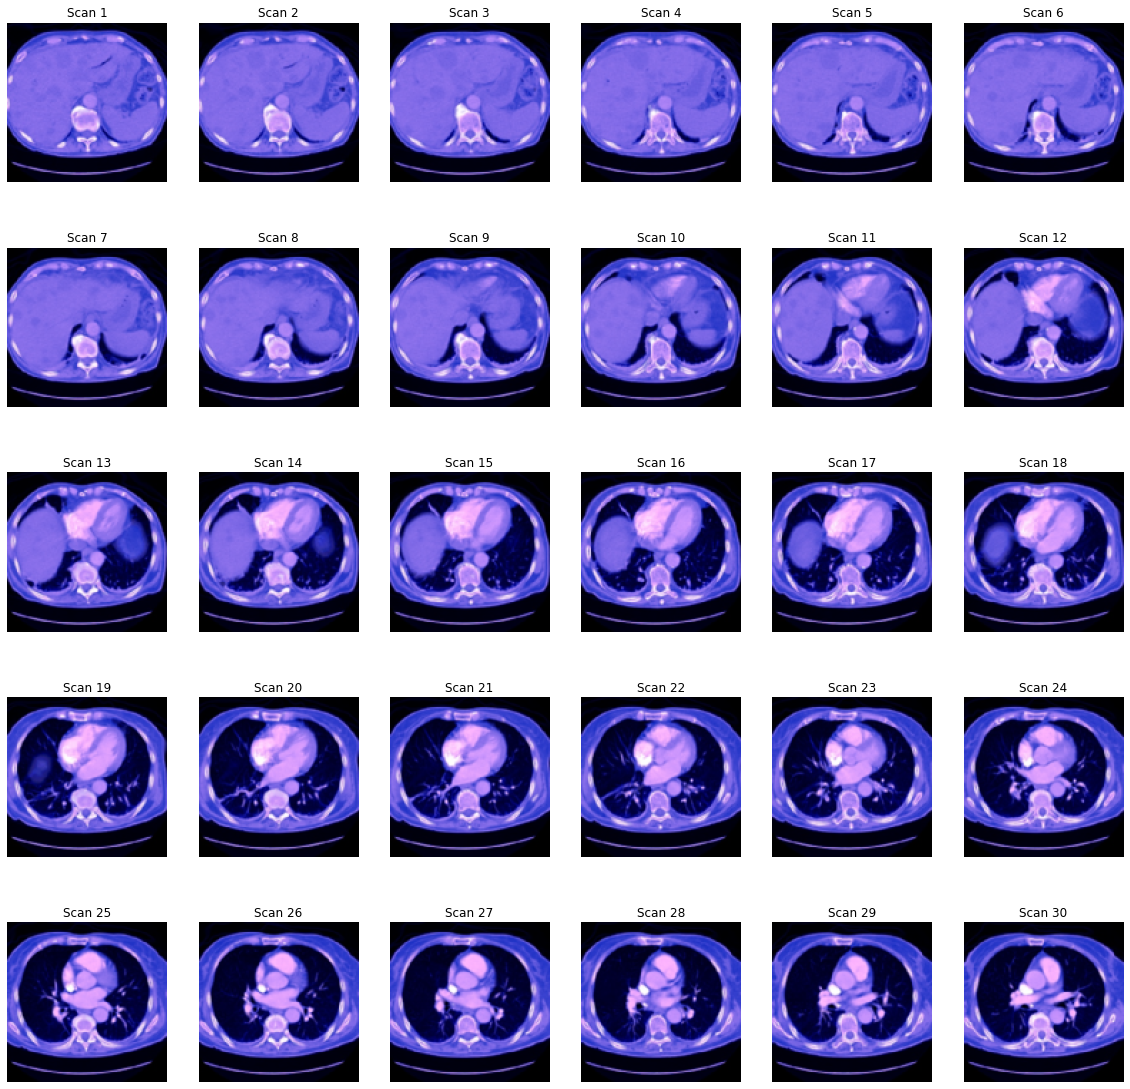

In [22]:
plot_scans(img_np)

# Processando os dados
Nessa transformação eu irei gravar no formato npz, nesse formato eu tenho uma quantidade menor de espaço que irei alocar e ganho na hora de utilizar o load da biblioteca numpy.

In [41]:
def processing_data():
    
    len_10_percent = int(len(df) * 0.1)
    
    for index, row in df.iterrows():
        
        if index % len_10_percent == 0 :
            print('Save date = ', index/len_10_percent * 10, ' %' )
        
        path_img = path + '/train-jpegs/' + row['StudyInstanceUID'] + '/' + row['SeriesInstanceUID']
        imgs_array = sorted([ path_img + '/' + img_path for img_path in listdir(path_img) ])
        imgs_input = np.stack([ np.asarray(cv2.imread(img)).astype(np.float32) for img in imgs_array ]).transpose(3,0,1,2)
        img_np = transform_data(imgs_input)    
        np.savez_compressed(path_img, img_np)
        

In [ ]:
processing_data()